<a href="https://colab.research.google.com/github/AlexanderPidodnya/TF_ud_course/blob/first/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22l08c06_forecasting_with_rnn_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c06_forecasting_with_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

keras = tf.keras
print(tf.config.list_physical_devices())

In [2]:
_URL  = 'https://storage.yandexcloud.net/aiueducation/Content/base/l11/SBER_MIN60.txt'
_URL1 = 'https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv'
_URL2 = 'https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv'
f_txt = tf.keras.utils.get_file('SBER_MIN60.txt', origin = _URL)
sb = pd.read_csv(f_txt, sep='\t')
y = np.array(sb.values[::,1], dtype=np.float)

2166919/2166919 [==============================] - 0s 0us/step


C:\Users\Администратор.SHTAUF\AppData\Local\Temp\2\ipykernel_6196\2820666398.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(sb.values[::,1], dtype=np.float)


In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

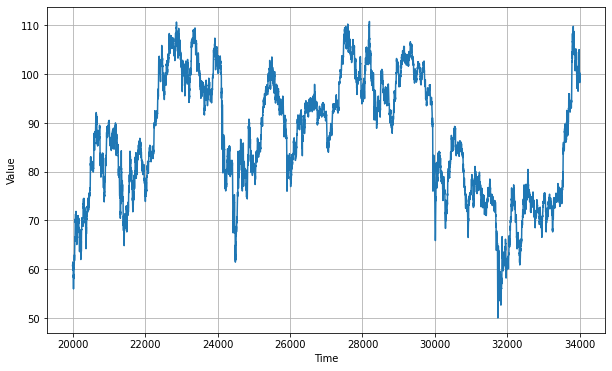

In [22]:
time = np.arange(len(y))

series = y[20000:34000]
time = time[20000:34000]

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [25]:
len(series)
time

array([20000, 20001, 20002, ..., 33997, 33998, 33999])

In [26]:
split_time = 10000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 50
train_set = window_dataset(x_train, window_size, batch_size=512)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 50
batch_size = 512
train_set = window_dataset(x_train, window_size, batch_size=batch_size)
valid_set = window_dataset(x_valid, window_size, batch_size=batch_size)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=20)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 / 10**(epoch / 30))
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[model_checkpoint], batch_size=batch_size)

Epoch 1/500


c:\python\.first_evn\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


     20/Unknown - 13s 558ms/step - loss: 43.0924 - mae: 43.5910INFO:tensorflow:Assets written to: my_checkpoint\assets
20/20 [==============================] - 17s 783ms/step - loss: 43.0924 - mae: 43.5910 - val_loss: 30.9834 - val_mae: 31.4808
Epoch 2/500
20/20 [==============================] - 14s 719ms/step - loss: 22.7588 - mae: 23.2566 - val_loss: 27.2297 - val_mae: 27.7272
Epoch 3/500
20/20 [==============================] - 15s 729ms/step - loss: 20.6445 - mae: 21.1409 - val_loss: 27.6826 - val_mae: 28.1814
Epoch 4/500
20/20 [==============================] - 17s 871ms/step - loss: 19.6238 - mae: 20.1210 - val_loss: 22.8126 - val_mae: 23.3105
Epoch 5/500
20/20 [==============================] - 15s 736ms/step - loss: 19.3233 - mae: 19.8198 - val_loss: 30.2824 - val_mae: 30.7820
Epoch 6/500
20/20 [==============================] - 17s 874ms/step - loss: 18.1951 - mae: 18.6923 - val_loss: 21.3975 - val_mae: 21.8951
Epoch 7/500
20/20 [==============================] - 16s 818ms/st

In [ ]:
model_rnn = keras.models.load_model("C:\python\.first_evn\TF_ud_course\my_checkpoint")

In [10]:
model

In [40]:
rnn_forecast = model_forecast(
    model, 
    series[split_time - window_size:-1],
    window_size)[:, 0]

125/125 [==============================] - 3s 20ms/step


In [41]:
len(x_valid), len(time_valid), len(rnn_forecast)

(4000, 4000, 4000)

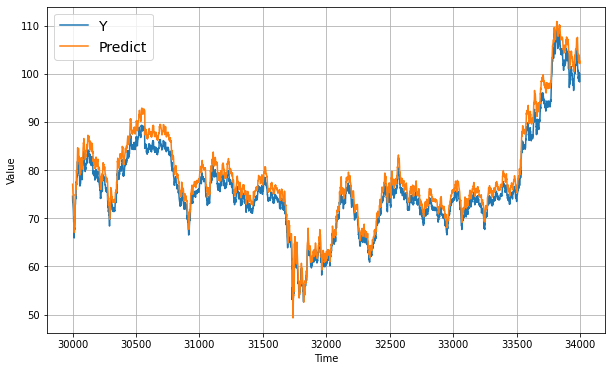

In [42]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,label="Y")
plot_series(time_valid, rnn_forecast, label='Predict')

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

## Sequence-to-Sequence Forecasting

In [43]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#window_size = 30
window_size = 50
batch_size = 512
#train_set = window_dataset(x_train, window_size, batch_size=batch_size)
#valid_set = window_dataset(x_valid, window_size, batch_size=batch_size)
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=batch_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 / 10**(epoch / 50))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [48]:
print(tf.config.list_physical_devices("GPU"))

[]


In [53]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 50
batch_size = 512
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=batch_size)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=batch_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=20)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[])

Epoch 1/500


c:\python\.first_evn\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


20/20 [==============================] - 19s 857ms/step - loss: 46.5388 - mae: 47.0370 - val_loss: 55.7710 - val_mae: 56.2702
Epoch 2/500
20/20 [==============================] - 17s 828ms/step - loss: 22.4612 - mae: 22.9582 - val_loss: 23.2680 - val_mae: 23.7663
Epoch 3/500
20/20 [==============================] - 16s 812ms/step - loss: 20.0733 - mae: 20.5699 - val_loss: 33.5268 - val_mae: 34.0267
Epoch 4/500
20/20 [==============================] - 17s 824ms/step - loss: 18.2902 - mae: 18.7861 - val_loss: 22.1826 - val_mae: 22.6813
Epoch 5/500
20/20 [==============================] - 17s 825ms/step - loss: 18.7972 - mae: 19.2940 - val_loss: 29.9553 - val_mae: 30.4546
Epoch 6/500
20/20 [==============================] - 17s 824ms/step - loss: 17.7454 - mae: 18.2416 - val_loss: 22.6576 - val_mae: 23.1561
Epoch 7/500
20/20 [==============================] - 16s 815ms/step - loss: 17.9906 - mae: 18.4872 - val_loss: 26.7933 - val_mae: 27.2922
Epoch 8/500
20/20 [===========================

In [54]:
s2s_rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
s2s_rnn_forecast = s2s_rnn_forecast[split_time - window_size:-1, -1, 0]

436/436 [==============================] - 7s 15ms/step


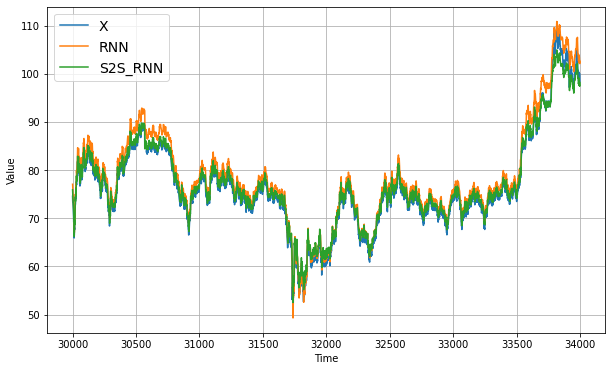

In [55]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = 'X')
plot_series(time_valid, rnn_forecast, label = 'RNN')
plot_series(time_valid, s2s_rnn_forecast, label = 'S2S_RNN')

In [59]:
print("MAE for RNN", keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
print("MAE for S2S RNN", keras.metrics.mean_absolute_error(x_valid, s2s_rnn_forecast).numpy())

MAE for RNN 2.144938
MAE for S2S RNN 0.98965746


# Stateful RNN
works only with batch_size = 1

In [78]:
def seq_window_dataset(series, window_size): #
    series = tf.expand_dims(series, axis =-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size+1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
s = [x for x in range(10)]
for i, (x, y) in enumerate(seq_window_dataset(s, 3)):
    print(i, x.numpy(), y.numpy(),)

In [79]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 50

train_set = seq_window_dataset(x_train, window_size)
valid_set = seq_window_dataset(x_valid, window_size)

srnn_model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful = True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
srnn_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model_checkpoint=keras.callbacks.ModelCheckpoint('srnn_chkpnt.h5', save_best_only=True)
reset_states = ResetStatesCallback()
srnn_model.summary()
srnn_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[model_checkpoint, reset_states])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (1, None, 100)            10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (1, None, 100)            20100     
                                                                 
 dense (Dense)               (1, None, 1)              101       
                                                                 
 lambda (Lambda)             (1, None, 1)              0         
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
199/199 [==============================] - 4s 15ms/step - loss: 10.1868 - mae: 10.6741 - val_loss: 15.6468 - val_mae: 16.1461
Epoch 2/500
199/199 [=========================

In [82]:
srnn_model.reset_states()
strnn_forecast = srnn_model.predict(series[np.newaxis,:, np.newaxis])
strnn_forecast = strnn_forecast[0, split_time -1: -1, 0]

1/1 [==============================] - 1s 751ms/step


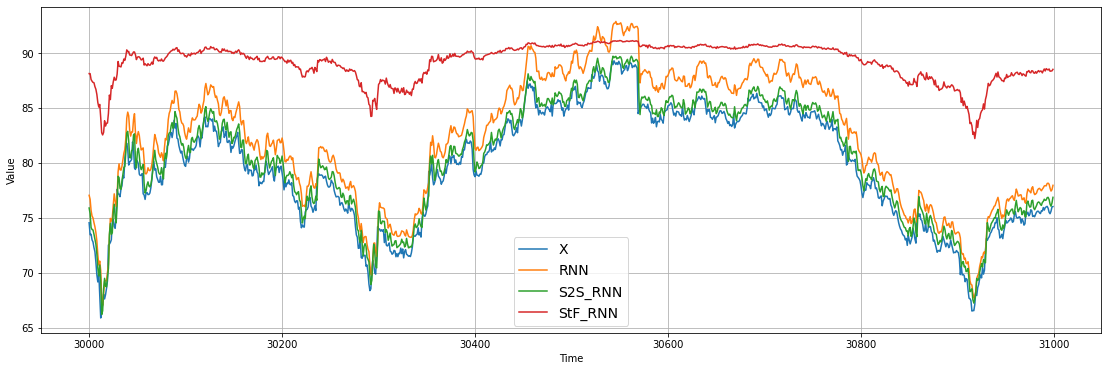

In [85]:
plt.figure(figsize=(19, 6))
plot_series(time_valid[:1000], x_valid[:1000], label = 'X')
plot_series(time_valid[:1000], rnn_forecast[:1000], label = 'RNN')
plot_series(time_valid[:1000], s2s_rnn_forecast[:1000], label = 'S2S_RNN')
plot_series(time_valid[:1000], strnn_forecast[:1000], label = 'StF_RNN')